In [1]:
from MClique import generate_clustered_network, perform_bond_percolation,remove_clusters, keep_clusters
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
#from scipy.interpolate import interp1d

15it [01:43,  6.92s/it]


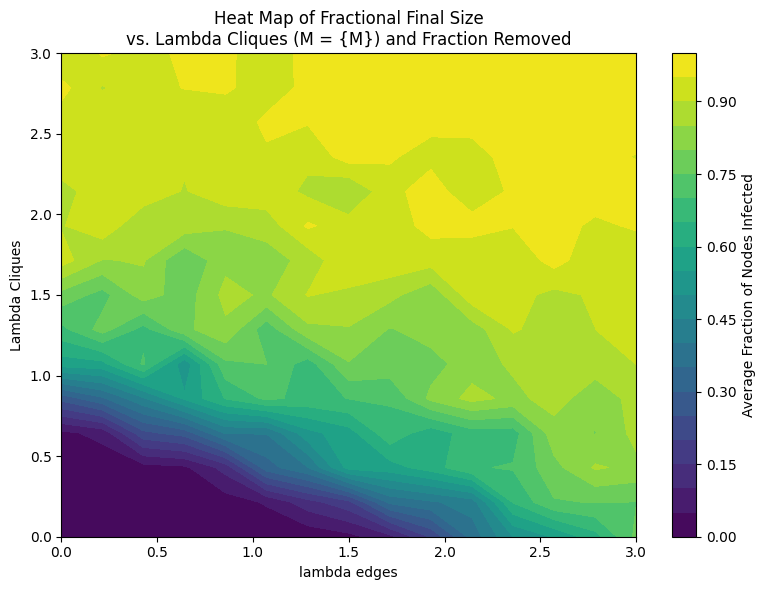

In [3]:
def perform_percolation(adj_matrix, p_i, initial_infected=1):
    """
    Performs percolation starting from randomly selected node(s).

    Parameters:
        adj_matrix (numpy.ndarray): Adjacency matrix of the network.
        p_i (float): Percolation probability (beta / (beta + gamma)).
        initial_infected (int): Number of initial infected nodes.

    Returns:
        fraction_infected (float): Fraction of nodes reached by percolation.
    """
    num_nodes = adj_matrix.shape[0]
    if num_nodes == 0:
        return 0.0  # Empty network

    # Copy the adjacency matrix
    percolated_adj = adj_matrix.copy()

    # Get indices of the upper triangle (since adj_matrix is symmetric)
    upper_tri_indices = np.triu_indices(num_nodes, k=1)
    edges = np.vstack(upper_tri_indices).T
    existing_edges = edges[percolated_adj[upper_tri_indices] > 0]

    # Randomly retain edges with probability p_i
    retain_mask = np.random.rand(len(existing_edges)) < p_i
    retained_edges = existing_edges[retain_mask]

    # Create a new adjacency matrix for the percolated graph
    percolated_adj = np.zeros_like(adj_matrix)
    percolated_adj[retained_edges[:, 0], retained_edges[:, 1]] = 1
    percolated_adj[retained_edges[:, 1], retained_edges[:, 0]] = 1  # Symmetric

    # Create a NetworkX graph from the percolated adjacency matrix
    G_perc = nx.from_numpy_array(percolated_adj)

    # Select initial infected nodes
    nodes = list(G_perc.nodes())
    if not nodes:
        return 0.0  # Empty graph after percolation

    initial_nodes = random.sample(nodes, min(initial_infected, len(nodes)))

    # Perform BFS from initial nodes to find reachable nodes
    infected_nodes = set()
    for initial_node in initial_nodes:
        infected_nodes.update(nx.node_connected_component(G_perc, initial_node))

    fraction_infected = len(infected_nodes) / num_nodes

    return fraction_infected

for M in [3]:
    N = 1000        # Total number of nodes in the network
    #M = 3          # Size of the cliques
    N_runs = 50     # Number of percolation simulations per combination

    beta = 0.2      # Infection probability per contact per time step
    gamma = 0.1     # Recovery probability per infected node per time step
    p_i = beta / (beta + gamma)  # Percolation probability

    # Range of lambda_cliques and s values
    lambda_cliques_list = np.linspace(0.0, 3.0, 15)  # From 0 to 3 in 7 steps
    #s_list = np.linspace(0.0, 0.9, 15)   
    lambda_edges_list = np.linspace(0.0, 3.0, 15)           # From 0 to 0.9 in 10 steps

    # Prepare a matrix to store average final sizes
    average_final_sizes = np.zeros((len(lambda_cliques_list), len(lambda_edges_list)))

    # for i, lambda_cliques in enumerate(lambda_cliques_list):
    #     print(f"Processing lambda_cliques = {lambda_cliques:.2f}")
    #     # Generate the network
    #     adj_matrix_full = generate_clustered_network(N, M, lambda_cliques=lambda_cliques)

    #     for j, s in enumerate(s_list):
    #         # Remove a fraction s of nodes uniformly
    #         num_nodes_full = adj_matrix_full.shape[0]
    #         num_nodes_to_remove = int(s * num_nodes_full)
    #         nodes_to_remove = random.sample(range(num_nodes_full), num_nodes_to_remove)
    #         nodes_to_keep = np.setdiff1d(np.arange(num_nodes_full), nodes_to_remove)

    #         # Create the reduced adjacency matrix
    #         adj_matrix_reduced = adj_matrix_full[np.ix_(nodes_to_keep, nodes_to_keep)]

    #         # If the network is empty, skip the simulation
    #         if adj_matrix_reduced.size == 0 or adj_matrix_reduced.shape[0] == 0:
    #             average_final_sizes[i, j] = 0
    #             continue

    #         fractions_infected = []
    #         for _ in range(N_runs):
    #             # Perform percolation
    #             fraction_infected = perform_percolation(adj_matrix_reduced, p_i)
    #             fractions_infected.append(fraction_infected)
    #         # Compute average fraction infected
    #         average_final_sizes[i, j] = np.mean(fractions_infected)

    for i, lambda_cliques in tqdm(enumerate(lambda_cliques_list)):
        for j, lambda_edges in enumerate(lambda_edges_list):

            #Generate network 
            adj_matrix = generate_clustered_network(N, M, lambda_edges=lambda_edges, lambda_cliques=lambda_cliques)

            # If the network is empty, skip the simulation
            if adj_matrix.size == 0 or adj_matrix.shape[0] == 0:
                average_final_sizes[i, j] = 0
                continue

            #Perform epidemic simualtion
            fractions_infected = []
            for _ in range(N_runs):
                # Perform percolation
                fraction_infected = perform_percolation(adj_matrix, p_i)
                fractions_infected.append(fraction_infected)
            # Compute average fraction infected
            average_final_sizes[i, j] = np.mean(fractions_infected)


    # Create the heat map
    lambda_edges_grid, lambda_cliques_grid = np.meshgrid(lambda_edges_list, lambda_cliques_list)

    plt.figure(figsize=(8, 6))
    plt.contourf(lambda_edges_grid, lambda_cliques_grid, average_final_sizes, levels=20, cmap='viridis')
    plt.colorbar(label='Average Fraction of Nodes Infected')
    plt.xlabel('lambda edges')
    plt.ylabel('Lambda Cliques')
    plt.title('Heat Map of Fractional Final Size\nvs. Lambda Cliques (M = {M}) and Fraction Removed')
    plt.tight_layout()
plt.show()


Seems okay, Now do point ditributions, so all have m M-cliques and k independent degree to get rid of poisson dist. randomness. 

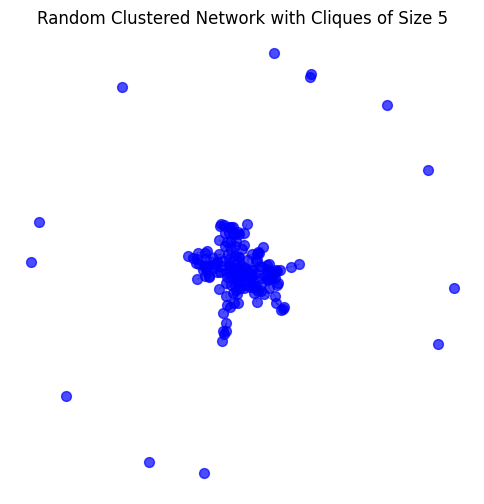

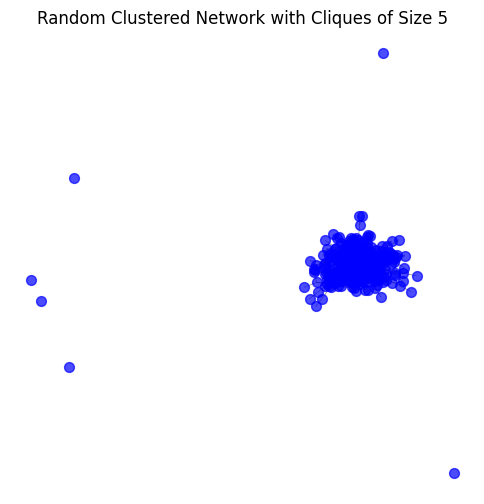

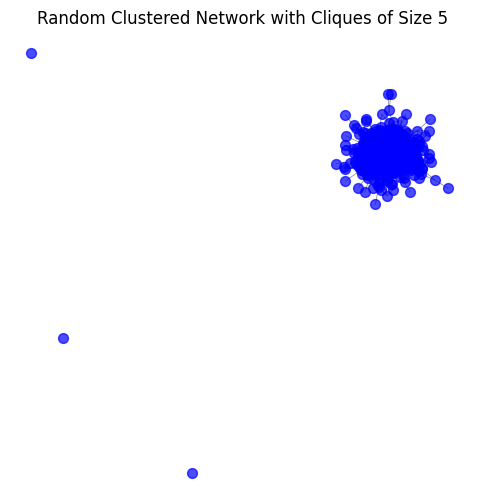

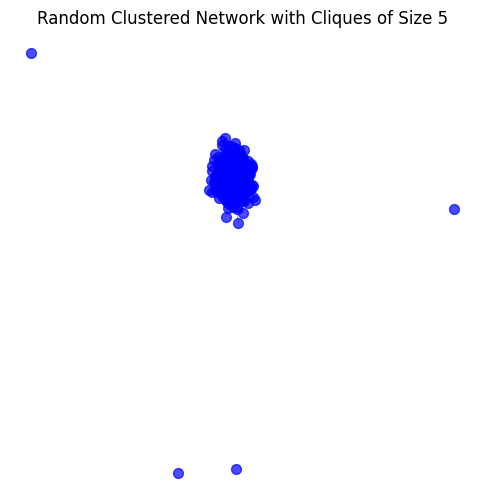

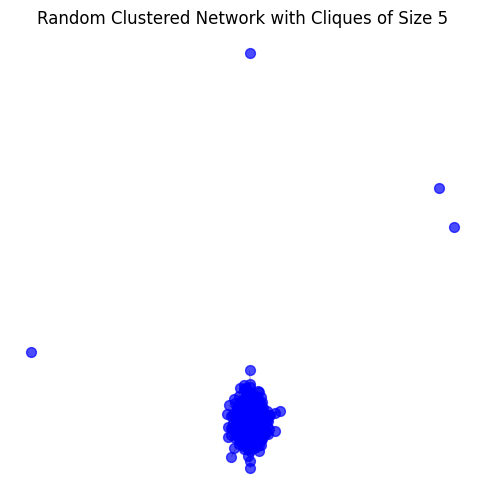

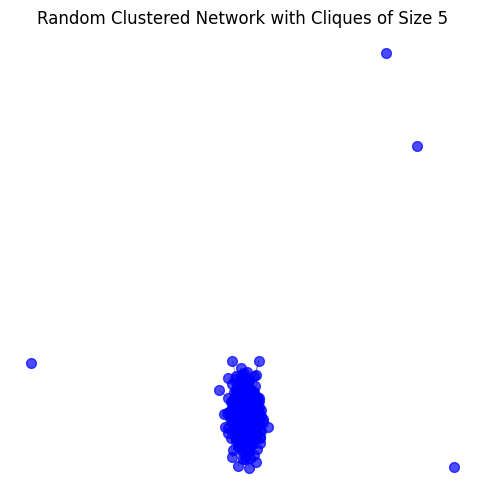

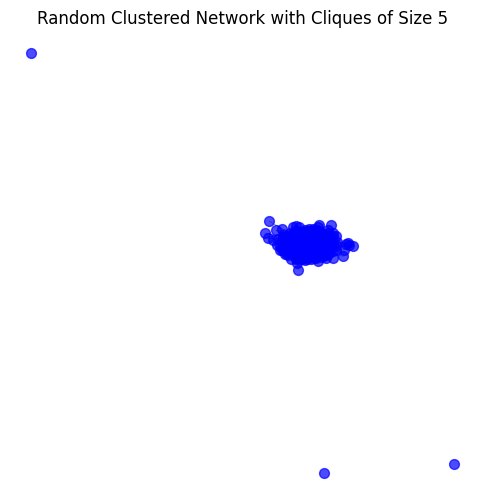

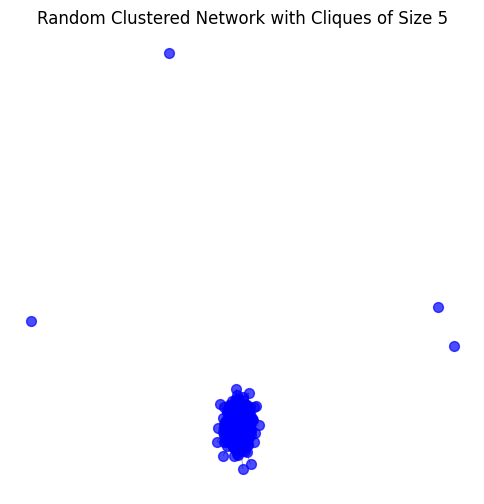

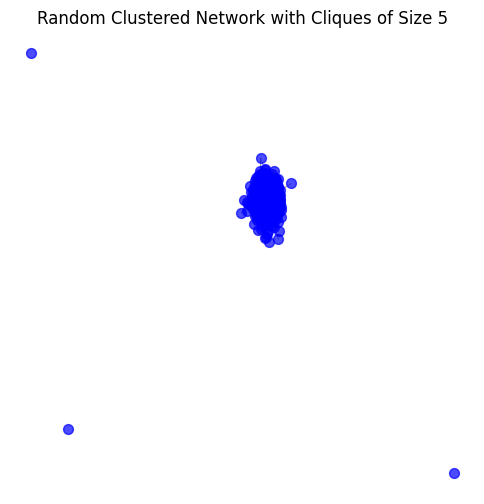

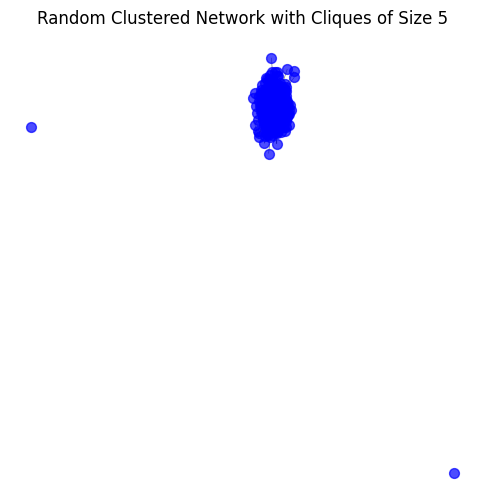

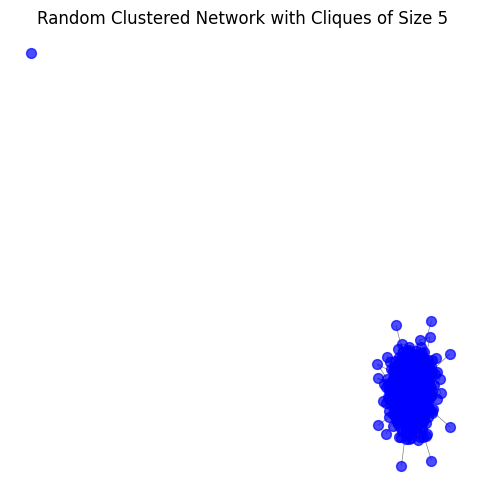

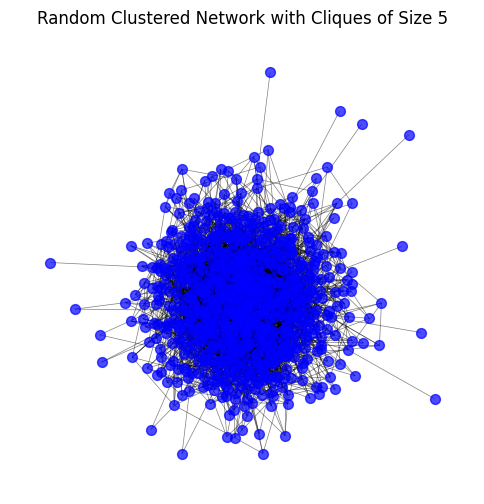

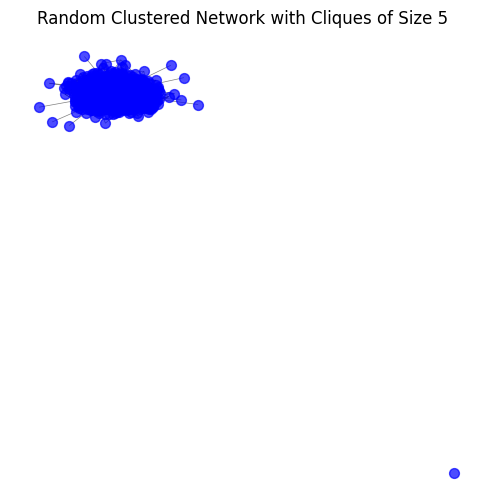

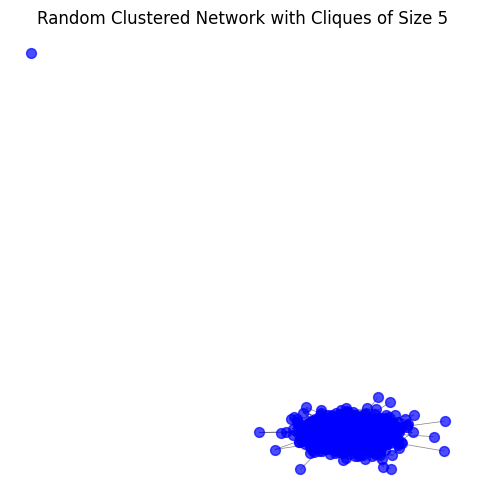

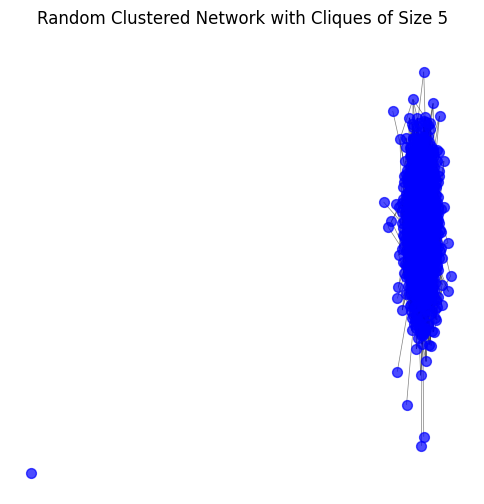

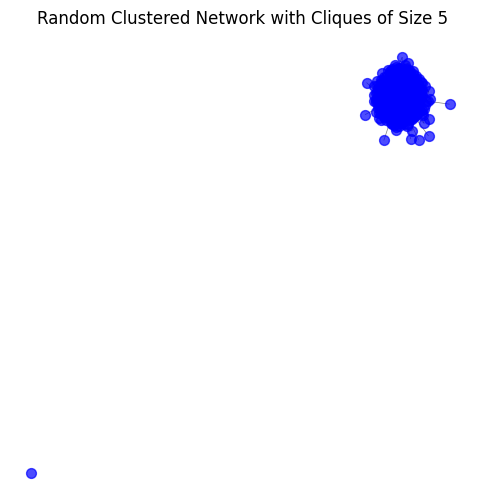

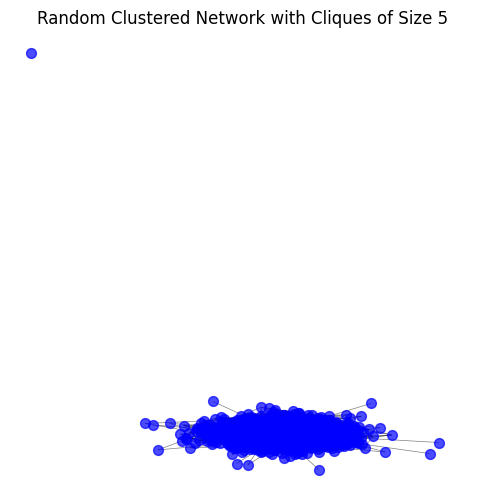

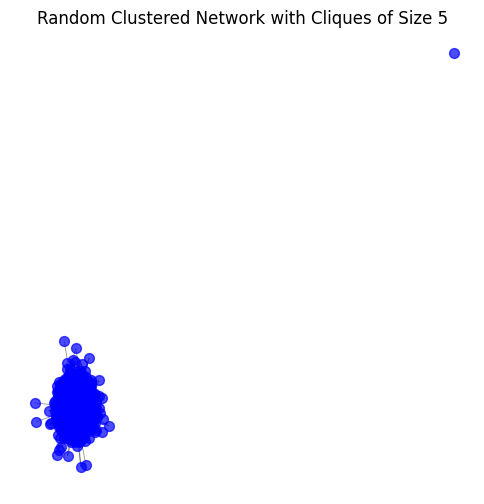

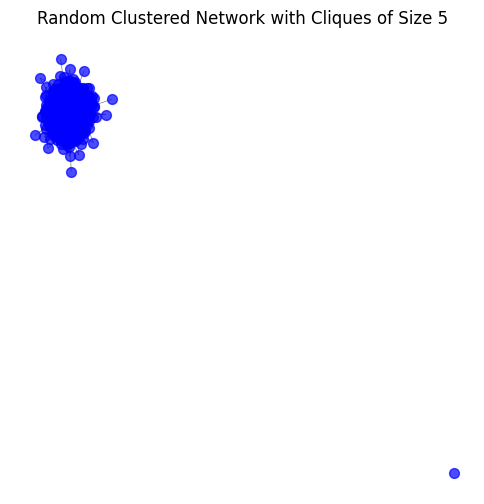

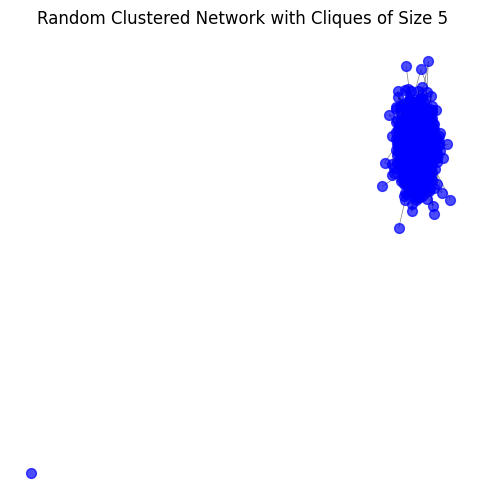

In [6]:
N = 1000   # Number of nodes in the network
M = 5     # Size of the cliques

# Generate the adjacency matrix
adj_matrix, cliques = generate_clustered_network(N, M, lambda_edges= 5)
for s_f in np.linspace(0.1,1,20):
    adj_matrix_plot = keep_clusters(adj_matrix=adj_matrix, cliques=cliques, s_f=s_f)

    # Create a NetworkX graph for visualization
    G = nx.from_numpy_array(adj_matrix_plot)

    # Draw the network
    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G, iterations=100)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue', alpha=0.7)

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)

    plt.axis('off')
    plt.title(f'Random Clustered Network with Cliques of Size {M}')
plt.show()

Percolation Progress: 100%|██████████| 101/101 [01:06<00:00,  1.52it/s]


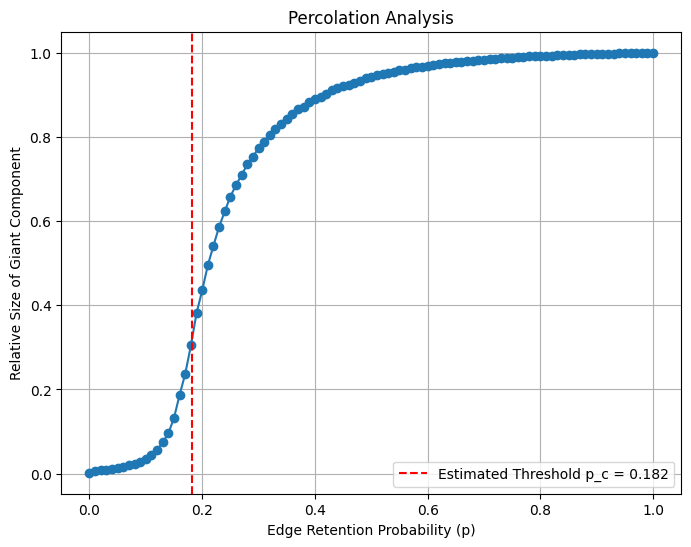

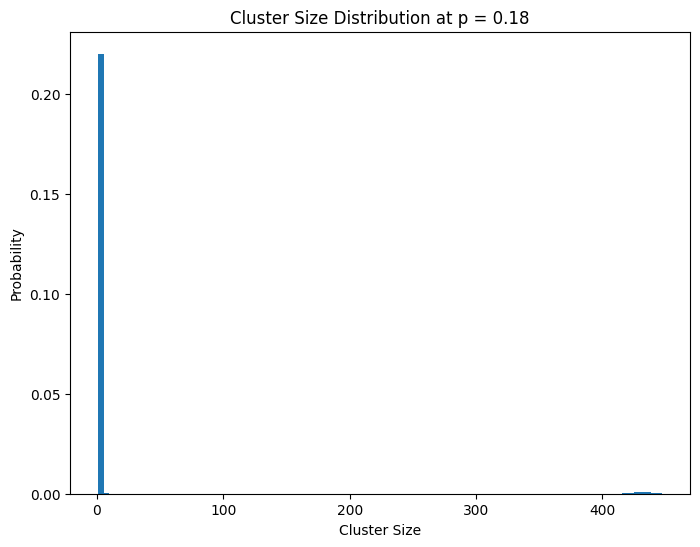

In [4]:
# Assume adj_matrix is obtained from the previous function generate_clustered_network
N = 500
M = 3
adj_matrix = generate_clustered_network(N, M)

# Define percolation parameters
N_p = 200  # Number of trials per p
p_values = np.linspace(0.0, 1.0, 101)  # Edge retention probabilities from 0 to 1

# Perform bond percolation
percolation_results = perform_bond_percolation(adj_matrix, N_p, p_values)

# Plot the size of the giant component vs. p
plt.figure(figsize=(8, 6))
plt.plot(percolation_results['p_values'], percolation_results['giant_component_sizes'], marker='o')
plt.axvline(percolation_results['percolation_threshold'], color='r', linestyle='--', label=f'Estimated Threshold p_c = {percolation_results["percolation_threshold"]:.3f}')
plt.title('Percolation Analysis')
plt.xlabel('Edge Retention Probability (p)')
plt.ylabel('Relative Size of Giant Component')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, plot the cluster size distribution at the percolation threshold
p_c_index = np.argmin(np.abs(percolation_results['p_values'] - percolation_results['percolation_threshold']))
cluster_sizes_at_pc = percolation_results['cluster_size_distributions'][p_c_index+20]

plt.figure(figsize=(8, 6))
plt.hist(cluster_sizes_at_pc, bins = 100, density=True)
plt.title(f'Cluster Size Distribution at p = {percolation_results["p_values"][p_c_index]:.2f}')
plt.xlabel('Cluster Size')
plt.ylabel('Probability')
plt.show()


Percolation Progress: 100%|██████████| 101/101 [01:20<00:00,  1.25it/s]


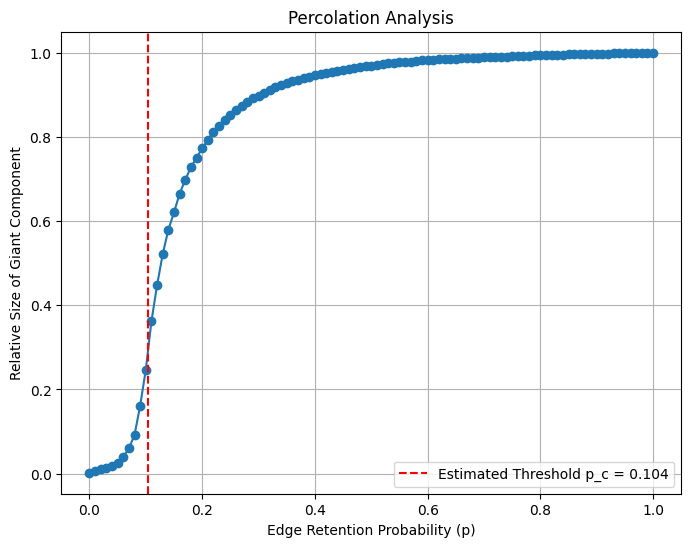

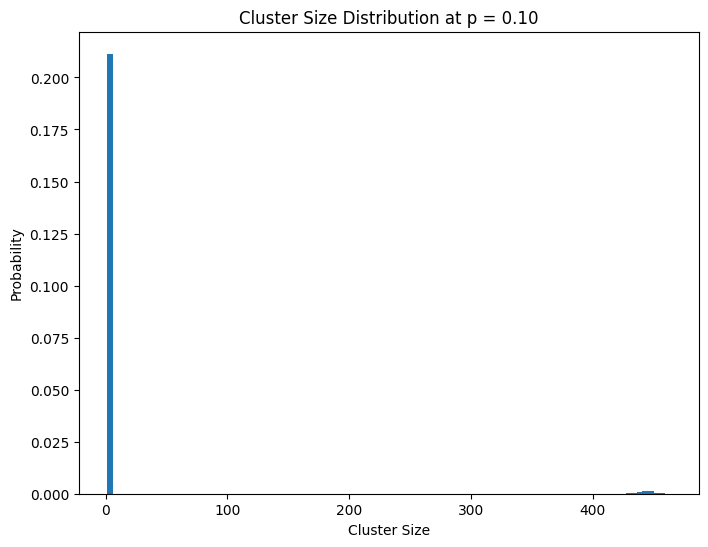

In [5]:
# Assume adj_matrix is obtained from the previous function generate_clustered_network
N = 500
M = 5
adj_matrix = generate_clustered_network(N, M)

# Define percolation parameters
N_p = 200  # Number of trials per p
p_values = np.linspace(0.0, 1.0, 101)  # Edge retention probabilities from 0 to 1

# Perform bond percolation
percolation_results = perform_bond_percolation(adj_matrix, N_p, p_values)

# Plot the size of the giant component vs. p
plt.figure(figsize=(8, 6))
plt.plot(percolation_results['p_values'], percolation_results['giant_component_sizes'], marker='o')
plt.axvline(percolation_results['percolation_threshold'], color='r', linestyle='--', label=f'Estimated Threshold p_c = {percolation_results["percolation_threshold"]:.3f}')
plt.title('Percolation Analysis')
plt.xlabel('Edge Retention Probability (p)')
plt.ylabel('Relative Size of Giant Component')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, plot the cluster size distribution at the percolation threshold
p_c_index = np.argmin(np.abs(percolation_results['p_values'] - percolation_results['percolation_threshold']))
cluster_sizes_at_pc = percolation_results['cluster_size_distributions'][p_c_index+20]

plt.figure(figsize=(8, 6))
plt.hist(cluster_sizes_at_pc, bins = 100, density=True)
plt.title(f'Cluster Size Distribution at p = {percolation_results["p_values"][p_c_index]:.2f}')
plt.xlabel('Cluster Size')
plt.ylabel('Probability')
plt.show()

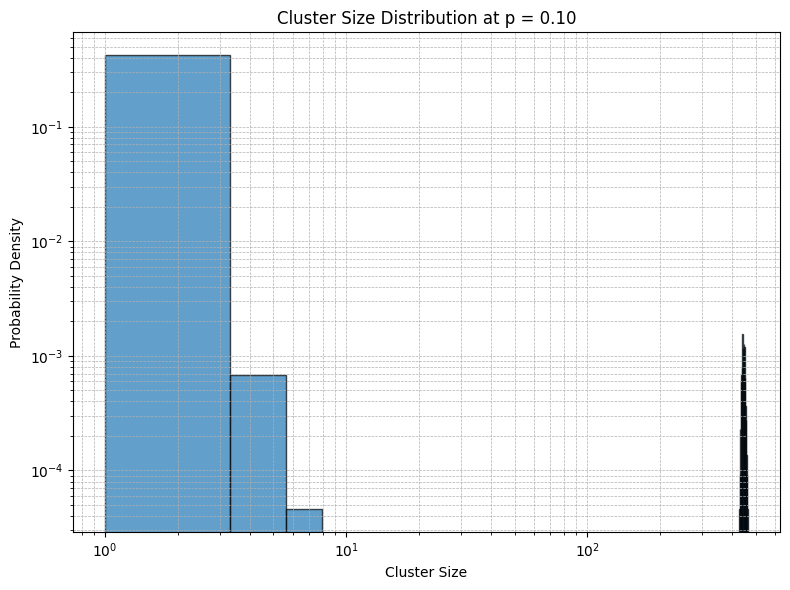

In [33]:
# Get the cluster sizes at the percolation threshold
p_c_index = np.argmin(np.abs(percolation_results['p_values'] - percolation_results['percolation_threshold']))
cluster_sizes_at_pc = percolation_results['cluster_size_distributions'][p_c_index+20]

# Remove clusters of size zero (if any)
cluster_sizes = [size for size in cluster_sizes_at_pc if size > 0]

# Create logarithmically spaced bins for the histogram
min_cluster_size = min(cluster_sizes)
max_cluster_size = max(cluster_sizes)
#bins = np.logspace(np.log10(min_cluster_size), np.log10(max_cluster_size), num=50)

# Plot the histogram on a log-log scale
plt.figure(figsize=(8, 6))
plt.hist(cluster_sizes, bins=200, density=True, log=True, edgecolor='black', alpha=0.7)

# Set the scales to logarithmic
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel('Cluster Size')
plt.ylabel('Probability Density')
plt.title(f'Cluster Size Distribution at p = {percolation_results["p_values"][p_c_index]:.2f}')

# Grid and layout adjustments
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


# What to ask now
- Can we produce the same analytical results as in Miller and Newman papers?
- How do we conduct the vaccination scheme (so how does clustering change outbreak prop - what fraction are in large cluster sizes/outbraks)?
    - This could involve picking uniformly to clusters in some way, and vaccinating/not vaccinating whole cliques, effectivly removing them from the graph
- As the mean number of M-cliques pr. nodes changes, how does the percolation parameter do so?
- Uniformly remove s nodes, vary "cliqueness" and record average outbreaksize.
- We should simulate results with cliques against simualtions with the same total degree without cliques



Remember we are assuming memmory-less (Markov property) and exponetially distributed waiting times to use $p_{infect} = \beta/(\beta+\nu)$

we should just jsut require self loops and isolated nodes to be discarded.